# Naive Bayes Generative Algorithm

In [2]:
import h5py
import sys
import numpy as np
import bisect

import matplotlib.pyplot as plt
import matplotlib.cm as cm

class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)

    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])


def use_subset(condition, x, y):
    sub_ix = np.where((y == condition[0]) | (y == condition[1]))
    y_sub = (y[sub_ix]).squeeze()
    # rename labels
    y_sub[y_sub == condition[0]] = 0
    y_sub[y_sub == condition[1]] = 1
    x_sub = (x[sub_ix, :]).squeeze()
    return x_sub, y_sub

In [3]:
f = h5py.File("data/digits.h5")
images = f["images"].value
labels = f["labels"].value
f.close()

print(images.shape)
print(labels.shape)

(120000, 9, 9)
(120000,)


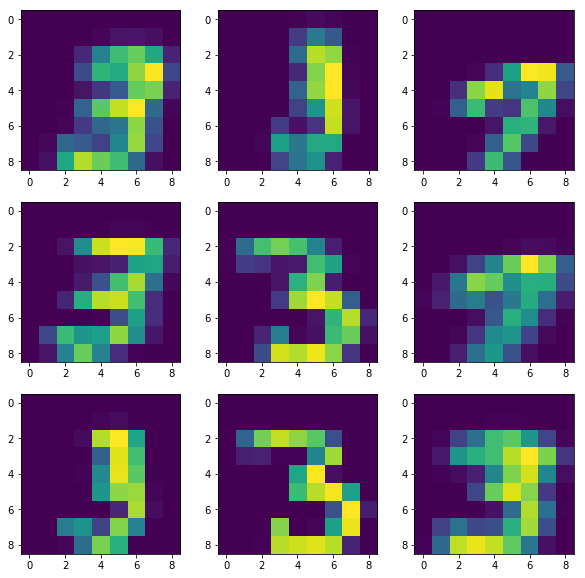

In [4]:
# use only digit 3
x, y = use_subset([3, 7], images, labels)

f, axarr = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    axarr[i % 3, i//3].imshow(x[i,:,:])

plt.show()

In [5]:
class GenerativeBayes(NaiveBayesClassifier):
    def sample_naive_bayes(self, digitIx):
        pxValue = np.zeros(len(self.histograms[digitIx]))
        for i, px in enumerate(self.histograms[digitIx]):
            ql = np.cumsum(px.heights)
            ql = ql / px.num_instances
            t = np.random.random_sample()
            l_ix = np.where(ql >= t)
            l = l_ix[0][0]
            pxValue[i] = (px.bin_edges[l + 1] - px.bin_edges[l]) * np.random.random_sample() + px.bin_edges[l]
        return pxValue

In [12]:
# reshape
x = np.reshape(x, (x.shape[0], -1))

gnb = GenerativeBayes()
gnb.train(x, y)

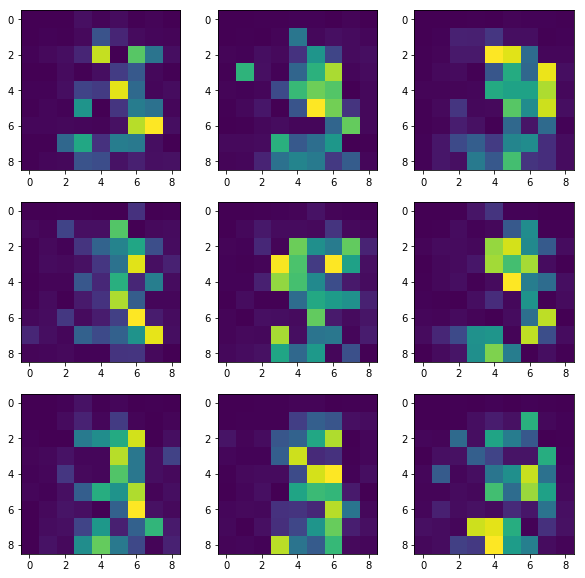

In [16]:
f, axarr = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    new_px = gnb.sample_naive_bayes(0)
    new_px = new_px.reshape(images[0,:,:].shape)
    axarr[i % 3, i//3].imshow(new_px)

plt.show()

# Tree

In [1]:
from sklearn.datasets import load_digits
from sklearn import cross_validation
import numpy as np
import pylab as plt
from copy import deepcopy
from queue import PriorityQueue
%matplotlib inline

/Users/lucasmueller/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#plotting 64, array as (8,8) gray picture
def image_show(data, title):
    data.shape = (8,8)
    plt.gray()
    plt.imshow(data)
    plt.title(title)
    plt.show()
    return

#loading data set
digits = load_digits()

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

x_all = data
y_all = target

#splitting data
x_train, x_test, y_train, y_test = \
    cross_validation.train_test_split(data, target, \
                                     test_size=0.4, random_state=0)

#extract threes from training set
x_threes = x_train[np.where(y_train == 3)]

In [5]:
class Node:
    
    threshold_number = 10
    
    def __init__(self, data, domain, split_dim, total_score, tree):
        self.left_child = None
        self.right_child = None
        self.pot_left_child = None
        self.pot_right_child = None
        self.features = data
        self.split_dim = split_dim
        self.total_score = total_score
        self.domain = domain
        self.tree = tree
        self.volume = np.prod([self.domain[i, 1] - self.domain[i, 0] \
                               for i in range(len(self.domain))])
        self.thresholds = self.thresholds()
        
        self.best_score = float('inf')
        self.left_domain = deepcopy(self.domain)
        self.right_domain = deepcopy(self.domain)
        self.left_features = None
        self.right_features = None
        self.left_score = None
        self.right_score = None
        
        self.score()
        
        tree.queue.put(self, self.best_score)
        
    def thresholds(self):
        lower = self.domain[self.split_dim, 0]
        upper = self.domain[self.split_dim, 1]
        dist = upper - lower
        step = dist / (self.threshold_number + 1)
        thresholds = []
        t = lower
        for i in range(self.threshold_number):
            t += step
            thresholds.append(t)
        return thresholds
            
    def score(self):
        next_split = self.tree.next_split(self.split_dim)
        self.left_child = Node(self.left_features, self.left_domain, next_split, self.left_score, \
                               self.tree)
        
        for t in self.thresholds:
            print('\nthreshold', t)
            left = self.features[np.where(self.features[:, self.split_dim] <= t)]
            print('left.shape:', left.shape)
            right = self.features[np.where(self.features[:, self.split_dim] > t)]
            print('right.shape:', right.shape)
            left_fraction = (t - self.domain[self.split_dim, 0]) / \
                               (self.domain[self.split_dim, 1] - self.domain[self.split_dim, 0])
            print('left fraction:', left_fraction)
            right_fraction = (self.domain[self.split_dim, 1] - t) / \
                              (self.domain[self.split_dim, 1] - self.domain[self.split_dim, 0])
            print('right fraction', right_fraction)
            p_left = len(left) / self.tree.num_instances / self.volume / left_fraction
            print('p_left', p_left)
            p_right = len(right) / self.tree.num_instances / self.volume / right_fraction
            print('p_right', p_right)
            left_score = p_left**2 * left_fraction * self.volume
            right_score = p_right**2 * right_fraction * self.volume
            score = left_score + right_score - self.total_score
            print('threshold:', t, 'gives score:', score)
            if score < self.best_score:
                self.best_score = score
                self.left_domain[self.split_dim, 1] = t
                self.right_domain[self.split_dim, 0] = t
                self.left_features = left
                self.right_features = right    
        return
    
    def split(self):
        next_split = tree.next_split(self.split_dim)
        self.left_child = Node(self.left_features, self.left_domain, next_split, self.left_score, \
                               self.tree)
        self.right_child = Node(self.right_features, self.right_domain, next_split, self.right_score, \
                               self.tree)
        self.tree.leaf_count += 1
        return

class Tree():
     
    def __init__(self, data, domain, num_leaves):
        self.data = data
        self.domain = domain
        self.num_leaves = num_leaves
        self.num_instances = len(data)
        self.volume = np.prod([self.domain[i, 1] - self.domain[i, 0] \
                               for i in range(len(self.domain))])
        self.initial_score = 1 / self.volume
        self.root = Node(self.data, self.domain, 0, self.initial_score, self)
        self.queue = PriorityQueue()
        self.leaf_count = 1
        
         
    def next_split(self, current):
        if current == data.shape[1] - 1:
            return 0
        else:
            return current + 1
        
    def build(self):
        while self.leaf_count < self.num_leaves:
            print('\nnumber of leaves now:', self.leaf_count)
            leaf_to_split = self.queue.get()
            leaf_to_split.split()
        return 

In [7]:
domain = np.empty((64, 2))
domain[:, 0] = 0
domain[:, 1] = 16

tree = Tree(x_threes, domain, 10)
root = Node(x_threes, domain, 50, 0, tree)
tree.build()

RecursionError: maximum recursion depth exceeded

# QDA Generative

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [58]:
# use only digit 3
x, y = use_subset([3, 7], images, labels)
# reshape
x = np.reshape(x, (x.shape[0], -1))

""" 
We used this built-in function becasue we think the authors spent more time on that than we did. 
Since we already submitted it once we hope that's fine.
"""
clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(x, y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=True, store_covariances=None, tol=0.0001)

In [59]:
mu = clf.means_[0,:]
cov_mat = clf.covariance_[0]
if not isPD(cov_mat):
    cov_mat = nearestPD(cov_mat)
    
y = np.random.multivariate_normal(mu, cov_mat, 12)

/Users/lucasmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


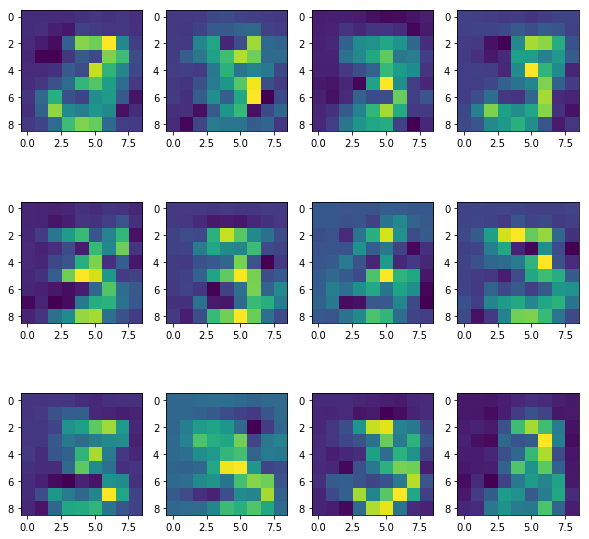

In [60]:
y = y.reshape(12, 9, 9)
f, axarr = plt.subplots(3, 4, figsize=(10, 10))
for i in range(12):
    axarr[i % 3, i//3].imshow(y[i,:,:])

plt.show()